In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import h5py
from ipywidgets import interact, IntSlider
from IPython.display import clear_output

SEED = 42 # Use same seed for replicable data generation
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

from FNO1D_utils import (
    data_loader,
    relative_min_max,
    normal_RMSE,
)
path = '/mimer/NOBACKUP/groups/ml_flame_storage/Max_1D/Data/1D5000.h5'
from FNO1D import FNO1d

train_loader, test_loader, inp_max, inp_min, out_max, out_min, x_max, x_min, y_max, y_min = data_loader(path, batch_size=100)

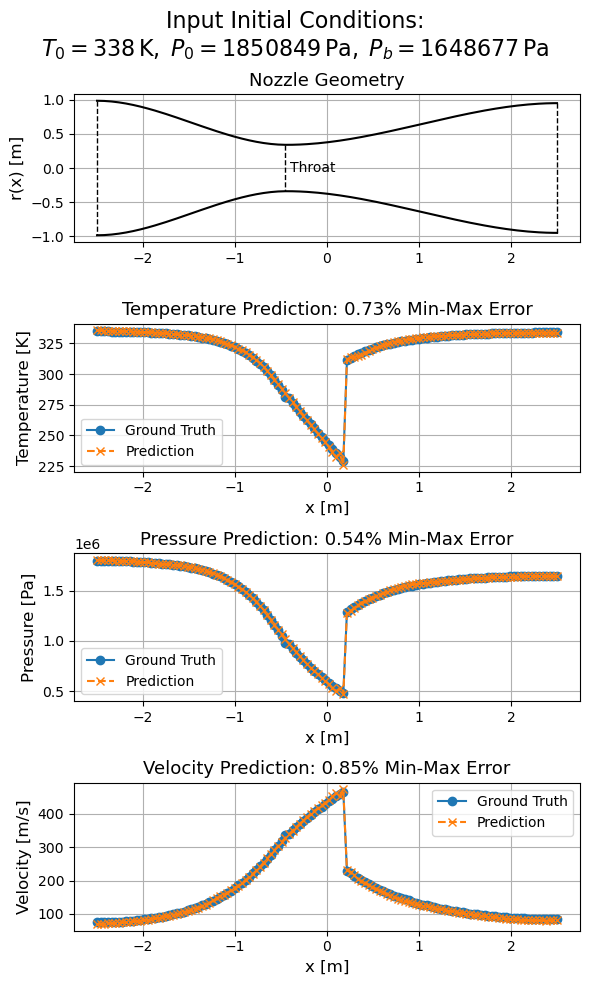

In [8]:
# ------------------------------------------------
# Line plots of one sample and batch
# ------------------------------------------------

# Load model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO1d(modes=16, width=32, hidden_mlp=128, N_x=128, N_fourier_layers=4).to(device)
model.load_state_dict(torch.load('1D5000Model.pth'))

# ------------------------------------------------
# Pick one batch and sample to visualize
# ------------------------------------------------
batch_index = 5
sample_idx = 1
with torch.no_grad():
    batch = next(itertools.islice(test_loader, batch_index, None))
    bc, target_field, x, y = batch
    bc = bc.to(device)
    target_field = target_field.to(device)
    x_batch = x.to(device)
    y_batch = y.to(device)
    pred_field = model(bc, x_batch, y_batch)

# ------------------------------------------------
# Rescale back from normalization if wanted
# ------------------------------------------------
pred_field = (pred_field.cpu().numpy())*(out_max-out_min) + out_min
#pred_field_norm = pred_field.cpu().numpy()

target_field = (target_field.cpu().numpy())*(out_max-out_min) + out_min
#target_field_norm = target_field.cpu().numpy()

x_batch = (x_batch.cpu().numpy())*(x_max - x_min) + x_min
y_batch = (y_batch.cpu().numpy())*(y_max - y_min) + y_min
y_batch = np.sqrt(y_batch/torch.pi)

grid_points = x_batch[0, :]
bc_sample_norm = bc[sample_idx, :].cpu().numpy() 
bc_sample = (bc[sample_idx, :].cpu().numpy())*(inp_max-inp_min) + inp_min


# Plotting geometry
x_inlet = grid_points[0]
x_outlet = grid_points[-1]
throat_index = np.argmin(y_batch[sample_idx, :])
x_throat = grid_points[throat_index]
y_inlet = y_batch[sample_idx, 0]
y_outlet = y_batch[sample_idx, -1]
y_throat = y_batch[sample_idx, throat_index]

fig, axes = plt.subplots(4, 1, figsize=(6, 10))

plt.suptitle(
    f"Input Initial Conditions:\n"
    rf"$T_0 = {bc_sample[0]:.0f}\,\mathrm{{K}},\; "
    rf"P_0 = {bc_sample[1]:.0f}\,\mathrm{{Pa}},\; "
    rf"P_b = {bc_sample[2]:.0f}\,\mathrm{{Pa}}$",
    fontsize=16
)

# More geometry plotting
axes[0].plot(grid_points, y_batch[sample_idx, :], 
             color='black')
axes[0].plot(grid_points, -y_batch[sample_idx, :], 
              color='black')
axes[0].set_ylabel('r(x) [m]', fontsize=12)
axes[0].set_title('Nozzle Geometry', fontsize=13)
axes[0].grid(True)

# Inlet line
axes[0].plot([x_inlet, x_inlet], [y_inlet, -y_inlet],
             color='black', linestyle='--', linewidth=1)
# Throat line
axes[0].plot([x_throat, x_throat], [y_throat, -y_throat],
             color='black', linestyle='--', linewidth=1)
# Outlet line
axes[0].plot([x_outlet, x_outlet], [y_outlet, -y_outlet],
             color='black', linestyle='--', linewidth=1)
# Throat text
axes[0].text(x_throat + 0.3, 0, 'Throat',
             horizontalalignment='center', verticalalignment='center',
             fontsize=10, color='black')

# Calulate relative error for each sample
pred = torch.from_numpy(pred_field[sample_idx,:,:]).unsqueeze(0)
target = torch.from_numpy(target_field[sample_idx,:,:]).unsqueeze(0)
sample_rel_min_max = relative_min_max(pred,target)*100

# Plotting loops
variable_names = ['Temperature Prediction', 'Pressure Prediction', 'Velocity Prediction']
axis_names = ['Temperature [K]', 'Pressure [Pa]', 'Velocity [m/s]' ]
variable_names = [
    f"{name}:{err:5.2f}% Min-Max Error"
    for name, err in zip(variable_names, sample_rel_min_max)
]

for i, ax in enumerate(axes[1:]):
    ax.plot(grid_points, target_field[sample_idx, :, i], 
            label='Ground Truth', marker='o', linestyle='-')
    ax.plot(grid_points, pred_field[sample_idx, :, i], 
            label='Prediction', marker='x', linestyle='--')
    ax.set_title(variable_names[i], fontsize=13)
    ax.set_xlabel('x [m]', fontsize=12)
    ax.set_ylabel(axis_names[i], fontsize=12)
    ax.legend()
    ax.grid(True)   
     
plt.tight_layout()
plt.show()


In [5]:
# ------------------------------------------------
# Line plot slider for samples and batches
# ------------------------------------------------

# Load model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO1d(modes=16, width=32, hidden_mlp=128, N_x=128, N_fourier_layers=4).to(device)
model.load_state_dict(torch.load('1D5000Model.pth'))
model.eval()


num_batches = len(test_loader)

# Grab a dummy batch to get batch size
dummy = next(itertools.islice(test_loader, 0, None))
batch_size = dummy[0].shape[0]

# Define outputs
variable_names = ['Temperature Prediction','Pressure Prediction','Velocity Prediction']
axis_names     = ['Temperature [K]','Pressure [Pa]','Velocity [m/s]']


def view(batch_idx, sample_idx):
    clear_output(wait=True)
    
    #  load the batch
    batch = next(itertools.islice(test_loader, batch_idx, None))
    bc, target_field, x, y = batch
    bc, target_field = bc.to(device), target_field.to(device)
    x_batch, y_batch = x.to(device), y.to(device)
    
    # Normalized data
    with torch.no_grad():
        pred_field = model(bc, x_batch, y_batch)
    pred_np   = pred_field.cpu().numpy()
    target_np = target_field.cpu().numpy()

    # Unnormalize geometry
    x_norm = (x_batch.cpu().numpy())*(x_max-x_min)+x_min
    y_norm = (y_batch.cpu().numpy())*(y_max-y_min)+y_min
    y_norm = np.sqrt(y_norm/np.pi)
    grid  = x_norm[0,:]

    fig, axes = plt.subplots(4,1,figsize=(8,10), tight_layout=True)

    # Geometry plot
    y_sample = y_norm[sample_idx]
    x_inlet, x_outlet = grid[0], grid[-1]
    throat_index = np.argmin(y_sample)
    x_throat, y_throat = grid[throat_index], y_sample[throat_index]
    axes[0].plot(grid,  y_sample, 'k-')
    axes[0].plot(grid, -y_sample, 'k-')
    for x0,y0 in [(x_inlet,y_sample[0]),(x_throat,y_throat),(x_outlet,y_sample[-1])]:
        axes[0].plot([x0,x0],[ y0,-y0],'--',c='k',lw=1)
    axes[0].text(x_throat+0.15,0,'Throat',ha='center',va='center')
    axes[0].set_title('Nozzle Geometry', fontsize=14); axes[0].set_ylabel('r(x) [m]', fontsize=12); axes[0].grid(True)

    # Compute errors for this sample
    pred   = torch.from_numpy(pred_np  [sample_idx]).unsqueeze(0)
    target   = torch.from_numpy(target_np[sample_idx]).unsqueeze(0)
    sample_rel_min_max = (relative_min_max(pred,target)*100).flatten()

    # Output plots
    for i, ax in enumerate(axes[1:]):
        ax.plot(grid, target_np[sample_idx,:,i],'o-',label='Ground Truth')
        ax.plot(grid, pred_np  [sample_idx,:,i],'x--',label='Prediction')
        ax.set_title(f"{variable_names[i]}: {sample_rel_min_max[i]:.2f}% Rel Min-Max", fontsize=14)
        ax.set_xlabel('x [m]', fontsize=12); ax.set_ylabel(axis_names[i], fontsize=12)
        ax.grid(True); ax.legend()
    plt.show()

# Two linked sliders
interact(
    view,
    batch_idx = IntSlider(min=0, max=num_batches-1, step=1, value=0, description='Batch'),
    sample_idx= IntSlider(min=0, max=batch_size-1, step=1, value=0, description='Sample')
)


interactive(children=(IntSlider(value=0, description='Batch', max=9), IntSlider(value=0, description='Sample',…

<function __main__.view(batch_idx, sample_idx)>